# Assignment 3
## Simen Nygard MTFYMA


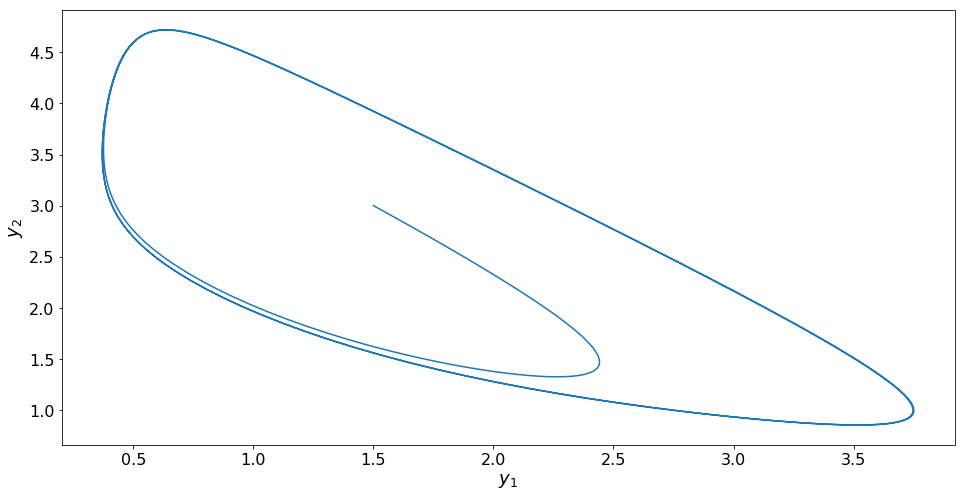

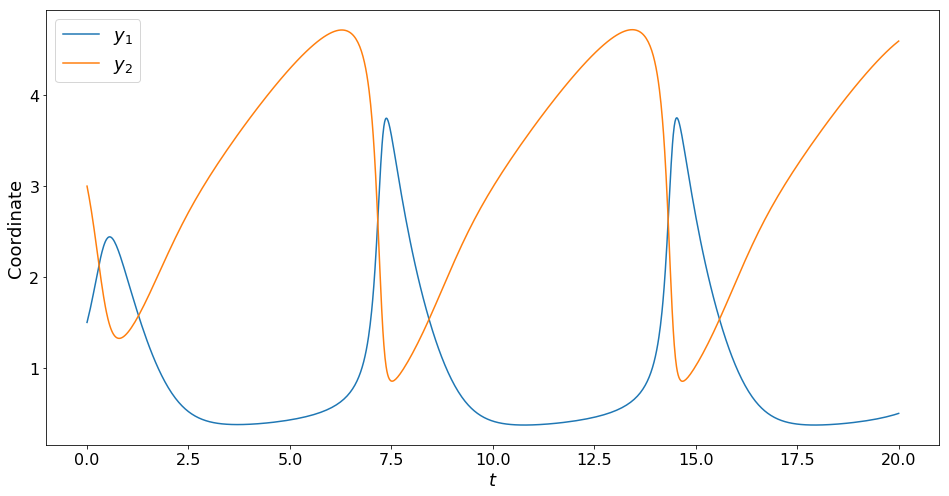

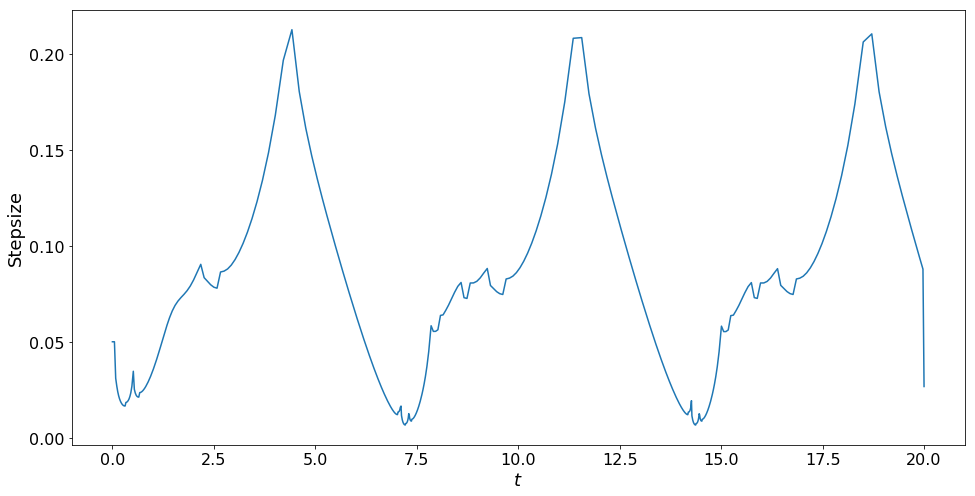

In [30]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from functools import wraps

%matplotlib inline

mpl.rcParams.update({'legend.fontsize': 18, 'legend.handlelength': 2, 'legend.fontsize': 18,
                     'axes.labelsize': 18, 'axes.titlesize': 18, 'figure.figsize': (16, 8),
                    'font.size':16})

def memoize(adaptive=False):    #decorator of K, associating state with K and wrapping function call   
    def adaptive_memoize(func):  

        func.cache= {}
        func.flag=not adaptive  #adaptive => False, non-adaptive => True

        @wraps(func)
        def memoized_func(*args, **kwargs):
            key = args[-1]

            if key in func.cache:
                ret=func.cache[key]

            else:
                ret=func.cache[key] = func(*args, **kwargs)

            if key == len(args[1]) - 1:
                if func.flag == True:
                    func.cache = {}      #Empty cache when higher order method calls K(y, A, h, 3), since next call of K
                    if adaptive:         #is with a different y. K(y, A, h, 3) is computed during lower order method,
                        func.flag=False  #but weighted with a 0 in this case
                else:
                    func.flag = True

            return ret

        return memoized_func
    return adaptive_memoize

def f(y):
    du = 1 + y[0] ** 2 * y[1] - 4 * y[0]
    dv = 3 * y[0] - y[0] ** 2 * y[1]
    return np.array([du, dv])


@memoize(adaptive=True)
def K(y, A, h, i):
    if len(A)==1:
        return f(y+A)
    else:
        return f(y + h * sum(0 if not A[i, j] else A[i, j] * K(y, A, h, j) for j in range(i + 1)))  # Assumes explicit A

def F(y, A, b, h):
    ret=sum((b[i] * K(y, A, h, i) for i in range(len(A))))
    return ret


def RKStep(y, A, b, h):
    x= y+ h * F(y, A, b, h)
    return x


def adapRKStep(y, A, b, h):
    x = np.array([RKStep(y, A, b[i], h) for i in range(2)])
    return x[-1], np.linalg.norm(x[0] - x[1], 2)


def simulation():
    A = np.array([[0, 0, 0, 0],
                  [1 / 2, 0, 0, 0],
                  [0, 3 / 4, 0, 0],
                  [2 / 9, 1 / 3, 4 / 9, 0]])

    b = np.array([[2 / 9, 1 / 3, 4 / 9, 0],
                  [7 / 24, 1 / 4, 1 / 3, 1 / 8]])


    t, h, y = start, h0, y0
    tArr = np.array([t])
    hArr = np.array([h])
    yArr = np.array([y])

    flag = True
    while flag:
        if t + h > end:
            h = end - t
            flag = False

        y1, e = adapRKStep(y, A, b, h)

        if e < TOL:
            y=y1
            t += h

            tArr = np.append(tArr, t)
            hArr = np.append(hArr, h)
            yArr = np.append(yArr, [y], axis=0)
            h =  (TOL / e) ** (1 / 3) * h

        else:
            h = P * (TOL / e) ** (1 / 3) * h

    return tArr, hArr, yArr


def visualiation(t, h, y):
    plt.plot(y[:,0],y[:,1])
    plt.gca().set(xlabel=r'$y_1$', ylabel=r'$y_2$')
    
    plt.figure()
    plt.plot(t,y[:,0], t, y[:,1])
    plt.gca().set(xlabel=r'$t$', ylabel='Coordinate')
    plt.legend(plt.gca().lines, (r'$y_1$',r'$y_2$'))

    plt.figure()
    plt.plot(t, h)
    plt.gca().set(xlabel=r'$t$', ylabel='Stepsize')
    plt.show()


def main():
    visualiation(*simulation())

if __name__=="__main__":
    y0 = np.array([1.5, 3])
    h0 = 1 / 20
    TOL = 1E-5
    P = 0.9
    start, end = 0, 20
    main()


Our stepsize varies periodically. We use a smaller stepsize where the components varies with a greater gradient, corresponding to the parts of the phase plot having the smallest curvature. The parts of the trajectory doing sharper turns corresponds to lesser change in the components, since we halt when tracing the trajectory in time. We initially start in the center of the phase plot, spiralling outwards, doing approximately two circulations of the outer circle. 